# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from lungpetctdx_dataset import LungPetCtDxDataset
from utils.wandb import start_wandb_run, wandb_watch, wandb_log



cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

'pynvml module not found, please install pynvml'

# Defining datasets (train/validation) 

In [4]:
from lungpetctdx_dataset import all_class_names

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(32),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Grayscale(),
])
ds = LungPetCtDxDataset(pre_normalize_transform=preprocess, post_normalize_transform=transforms.Grayscale(),
    exclude_classes=[all_class_names[1],all_class_names[2]], normalize=True)
trainSet, valSet = random_split(ds, [0.8, 0.2])
dataloaders = {
    "train": torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=4)
}
num_classes = len(ds.class_names)
dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

# Defining model 

In [5]:
from capsule_net import CapsNet
from capsnet_config import Config

config = Config(cnn_in_channels=1,reconstruction_loss_factor=10, dc_num_capsules=num_classes)
model = CapsNet(config)

start_wandb_run(config)

wandb_watch(model)
model.to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tfiedlerdev (7-vs-capsule). Use `wandb login --relogin` to force relogin


CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

# Setup training

In [6]:
from tqdm.notebook import tqdm
from plot import refreshPlot
def predicted_indices_from_outputs(outputs):
    classes = torch.sqrt((outputs ** 2).sum(2))
    _, max_length_indices = classes.max(dim=1)
    return torch.squeeze(max_length_indices)


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = []
    batchEnumeration = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        epoch_result = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, reconstructions, _ = model(inputs)
                    preds = predicted_indices_from_outputs(outputs)
                    loss = model.loss(inputs, outputs, labels, reconstructions)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_size = inputs.size(0)
                batch_loss = loss.item() * batch_size
                losses.append(batch_loss)
                batchEnumeration.append(batchEnumeration[-1]+1 if len(batchEnumeration)>0 else 0)

                running_loss += batch_loss
                _, labels_index = torch.max(labels.data, 1)
                batch_num_correct = torch.sum(preds ==labels_index)
            
                running_corrects += batch_num_correct
                if idx % 10 == 0:
                    batch_size = inputs.size(0)
                    tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}, loss: {:.6f}".format(
                        epoch,
                        num_epochs,
                        idx + 1,
                        len(dataloaders[phase]),
                        batch_num_correct / float(batch_size),
                        batch_loss / float(batch_size)
                        ), end="\r")
                    
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            epoch_result[phase] = {"acc": epoch_acc, "loss": epoch_loss}

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        wandb_log(epoch_result)
        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    refreshPlot([(batchEnumeration, losses, "Training losses")])
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define training parameters

In [7]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

Epoch 0/9
----------
train Loss: 3.4551 Acc: 0.7340], train accuracy: 0.718750, loss: 2.281429
val Loss: 2.2751 Acc: 0.735670], train accuracy: 0.593750, loss: 2.294392

Epoch 1/9
----------
train Loss: 2.1944 Acc: 0.7340], train accuracy: 0.625000, loss: 2.170764
val Loss: 2.1491 Acc: 0.735670], train accuracy: 0.875000, loss: 2.122219

Epoch 2/9
----------
train Loss: 2.1330 Acc: 0.7340], train accuracy: 0.718750, loss: 2.124253
val Loss: 2.1208 Acc: 0.735670], train accuracy: 0.812500, loss: 2.105169

Epoch 3/9
----------
train Loss: 2.1141 Acc: 0.7340], train accuracy: 0.593750, loss: 2.139538
val Loss: 2.1080 Acc: 0.735670], train accuracy: 0.875000, loss: 2.077258

Epoch 4/9
----------
train Loss: 2.1042 Acc: 0.7340], train accuracy: 0.812500, loss: 2.082837
val Loss: 2.1002 Acc: 0.735670], train accuracy: 0.781250, loss: 2.089649

Epoch 5/9
----------
train Loss: 2.1002 Acc: 0.7340], train accuracy: 0.687500, loss: 2.110774
val Loss: 2.0995 Acc: 0.735670], train accuracy: 0.6562

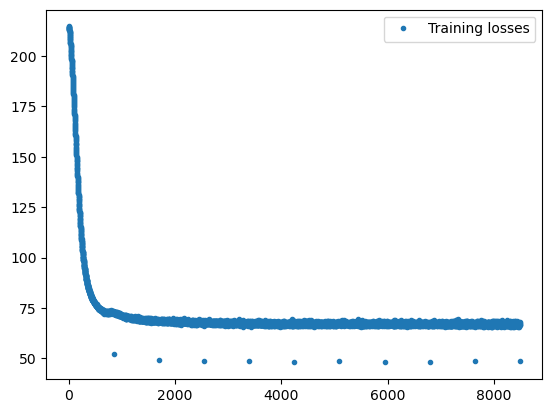

In [12]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

# Evaluation

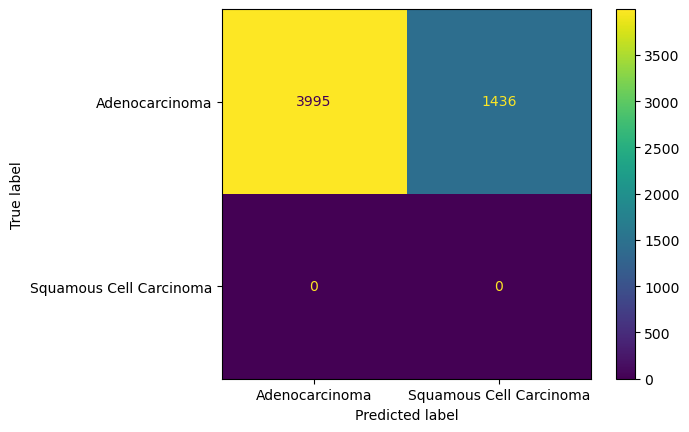

F1-score: 0.8476554211754721


In [9]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


y_true = np.array([])
y_pred = np.array([])
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs, _, _ = model(inputs)
        
        
        preds = predicted_indices_from_outputs(outputs).cpu()
        _, labels = torch.max(classes.cpu(), 1)
    
        y_true = np.concatenate((y_true, preds))
        y_pred = np.concatenate((y_pred, labels))
        
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=ds.class_names)
disp.plot()
plt.show()
print("F1-score:",f1_score(y_true, y_pred, average="weighted") )

# Visualize reconstruction samples


In [10]:
from skimage.metrics import structural_similarity as ssim

def mse(imageA: np.ndarray, imageB: np.ndarray):

	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA- imageB) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
def compare_images(images: list[tuple[torch.Tensor, torch.Tensor]], title):
	
	#s = ssim(imgAnp, imgBnp)
	# setup the figure
	fig = plt.figure(title, figsize=(2, len(images)))
	fig.set_size_inches(10, 5*len(images))
	for i, (imageA, imageB) in enumerate(images):
		imgAnp, imgBnp = imageA.cpu().numpy().transpose((1,2,0)), imageB.cpu().numpy().transpose((1,2,0))
		# compute the mean squared error and structural similarity
		# index for the images
		m = mse(imgAnp, imgBnp)
		plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, 0))
		# show first image
		ax = fig.add_subplot(len(images), 2, i*2+1)
		plt.imshow(imgAnp)
		plt.axis("off")
		# show the second image
		ax = fig.add_subplot(len(images), 2, i*2+2)
		plt.imshow(imgBnp)
		plt.axis("off")
	# show the images
	plt.show()

inputs shape torch.Size([32, 1, 32, 32])
reconstructions shape torch.Size([32, 1, 32, 32])


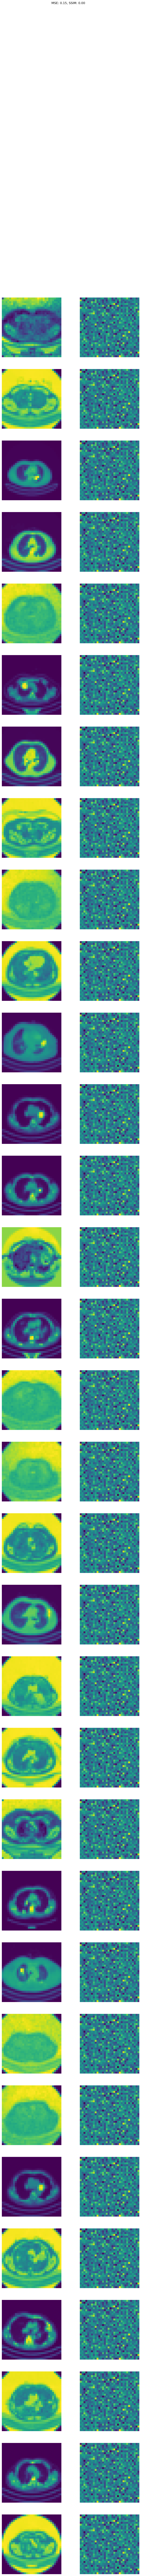

In [15]:
with torch.no_grad():
    inputs, classes = next(iter(dataloaders['train'])) 
    dataloaders['val']
    inputs = inputs.to(device)
    classes = classes.to(device)
    outputs, reconstructions, _ = model(inputs)
    preds = predicted_indices_from_outputs(outputs).cpu()
    _, labels = torch.max(classes.cpu(), 1)

    y_true = np.concatenate((y_true, preds))
    y_pred = np.concatenate((y_pred, labels))
    print("inputs shape", inputs.size())
    print("reconstructions shape", reconstructions.size())
    compare_images([(inputs[i], reconstructions[i]) for i in range(reconstructions.size(0))], "Predicted: "+str(y_true[0])+ "/ Actual: "+str(y_pred[0]))